In [57]:
%matplotlib inline
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import theano

from sklearn.datasets import make_blobs, make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# Local imports
from experiments.data import make_weak_true_partition, label_binarize, generateWeak, binarizeWeakLabels
from experiments.visualizations import plot_heatmap, plot_confusion_matrix, plot_multilabel_scatter
from wlc.WLweakener import computeM, estimate_M

cmap = cm.get_cmap('Accent')

# 1. Toy example

## 1.a. Configurable parameters

In [58]:
# Dataset parameters
TOY_EXAMPLE = 'Classification' # Gaussians
n_samples = 3000
std = 10
n_classes = 3
n_centers = 3
n_features = 10

# Weak label model
m_method = 'random_weak'
m_alpha = 0.7 # Alpha = 1.0 No unsupervised in IPL
m_beta = 0.5 # Beta = 0.0 No noise


# Classifier model
modeltype = 'logreg'

# Random generator
seed = 42

# True and weak, train and test, proportions
true_proportion = 0.4 # proportion of data with true labels
test_proportion = 0.95 # proportion of data with true labels that will be used for test only

## 1.b. Generating random clean data

We will generate $N_{classes}$ classes comming each from a Gaussian distribution

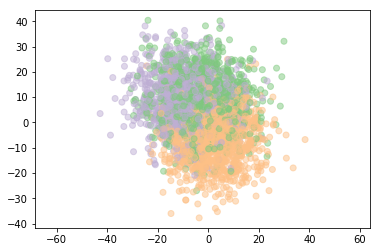

In [59]:
if TOY_EXAMPLE == 'Ad-Hoc':
    means = [[-1, -1],
             [-1, 1],
             [1, 1]]
    n_classes = len(means)
    n_features = len(means[0])
    X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=means,
                      cluster_std=std, random_state=seed)   
elif TOY_EXAMPLE == 'Gaussians':
    X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_classes,
                      cluster_std=std, random_state=seed)
elif TOY_EXAMPLE == 'Classification':
    n_centers = n_classes
    X, y =  make_blobs(n_samples=n_samples, n_features=n_features, centers=n_centers,
                       cluster_std=std, random_state=seed)
    # y[y < 5] = 0
    # y[y > 7] = 1
    #y[y > 1] = 2
 
plt.scatter(X[:,0], X[:,1], c=cmap(y), alpha=0.5)
plt.axis('equal')
plt.show()

## 1.c. Specifying the mixing process with a matrix M

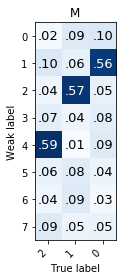

In [60]:
M = computeM(c=n_classes, method=m_method, alpha=m_alpha, beta=m_beta)

fig = plot_heatmap(M, title='M', columns=list(reversed(range(n_classes))), 
                   xlabel='True label', ylabel='Weak label')

## 1.d. Applying the mixing process to a portion of the clean data

- $S_w$ denotes the dataset with only weak labels
- $S_{wt}$ denotes the dataset with both weak and true labels
- $S_{wt-test}$ denotes the dataset with both weak and true labels but will be used only for test purposes

In [61]:
def make_weak_true_partition2(M, X, y, true_size=0.1, random_state=None):
    """ This is an adaptation of experiments.data.make_weak_true_partition() 
        that returns the true labels of the weak fold too.
    """
    n_c = len(np.unique(y))
    classes = range(0, n_c)
    assert(n_c == np.max(y)+1)
    Y = label_binarize(y, classes)
    z = generateWeak(y, M, seed=random_state)
    Z = binarizeWeakLabels(z, c=n_c)

    # Create partition for weak and true labels
    sss = StratifiedShuffleSplit(n_splits=1, test_size=true_size,
                                 random_state=random_state)
    for weak_fold, true_fold in sss.split(X, y):
        # Weaken the true labels fold using the mixing matrix M
        X_w = X[weak_fold]
        z_w = z[weak_fold]
        Z_w = Z[weak_fold]
        y_w = y[weak_fold]
        Y_w = Y[weak_fold]

        # Select the true labels fold
        X_t = X[true_fold]
        z_t = z[true_fold]
        Z_t = Z[true_fold]
        y_t = y[true_fold]
        Y_t = Y[true_fold]

    # TODO refactor name convention of train and val, for weak and true
    training = (X_w, Z_w, z_w, Y_w, y_w)
    validation = (X_t, Z_t, z_t, Y_t, y_t)

    return training, validation

Weak set size = 1800
Weak/true training set size = 60
Weak/true test set size = 1140


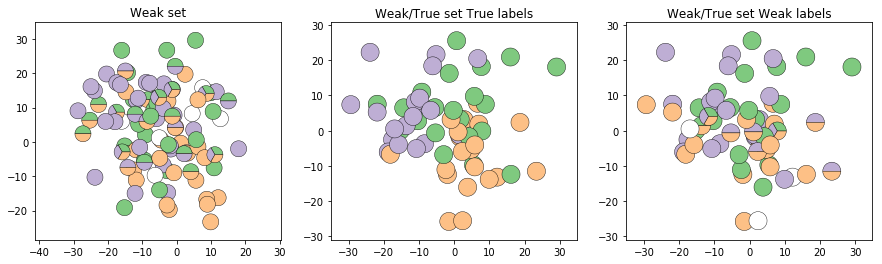

In [62]:
weak_set, weak_and_true_set = make_weak_true_partition2(
    M, X, y, true_size=true_proportion, random_state=seed)
(X_w, Z_w, z_w, Y_w, y_w) = weak_set

splits = train_test_split(*weak_and_true_set, test_size=test_proportion)
X_wt_train, Z_wt_train, z_wt_train, Y_wt_train, y_wt_train = splits[0::2]
X_wt_test, Z_wt_test, z_wt_test, Y_wt_test, y_wt_test = splits[1::2]

print('Weak set size = ' + str(len(X_w)))
print('Weak/true training set size = {}'.format(len(X_wt_train)))
print('Weak/true test set size = {}'.format(len(X_wt_test)))


fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1)
_ = plot_multilabel_scatter(X_w[:100], Z_w[:100], fig=fig,
                            ax=ax, title='Weak set', cmap=cmap)
ax = fig.add_subplot(1, 3, 2)
_ = plot_multilabel_scatter(X_wt_train[:100], Y_wt_train[:100], fig=fig,
                            ax=ax, title='Weak/True set True labels', cmap=cmap)
ax = fig.add_subplot(1, 3, 3)
_ = plot_multilabel_scatter(X_wt_train[:100], Z_wt_train[:100], fig=fig,
                            ax=ax, title='Weak/True set Weak labels', cmap=cmap)

# 2. Performance bounds

## 2.a. Baseline

Training a baseline classifier with only the true labels available for training

Coefficients
[[-4.49278135e-02  3.73922147e-01  1.25667836e-01  1.33885607e-01
   1.11648740e-02 -2.06877265e-01 -7.07945159e-04  8.61582251e-03
  -1.02113536e-01  2.26141668e-01]
 [-2.27537518e-01  4.50509921e-01  2.23150817e-01 -1.08078456e-01
   5.83903745e-02 -3.02318701e-01 -3.11036337e-02 -3.67310825e-02
  -5.75679316e-02  1.64117602e-01]
 [ 2.72465331e-01 -8.24432067e-01 -3.48818653e-01 -2.58071514e-02
  -6.95552484e-02  5.09195966e-01  3.18115789e-02  2.81152600e-02
   1.59681468e-01 -3.90259270e-01]]
Intercepts
[ 2.29353134 -0.74446124 -1.5490701 ]


/Users/jcid/anaconda/envs/wll/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


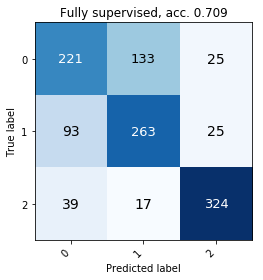

In [63]:
clf = LogisticRegression(solver='lbfgs', multi_class='multinomial')
clf.fit(X_wt_train, y_wt_train)
clf_proba = clf.predict_proba(X_wt_test)
clf_pred = clf_proba.argmax(axis=1)

cm = confusion_matrix(y_wt_test, clf_pred)
_ = plot_confusion_matrix(
        cm, title='Fully supervised, acc. {:.3}'.format((y_wt_test == clf_pred).mean()))

print('Coefficients')
print(clf.coef_)
print('Intercepts')
print(clf.intercept_)

## 2.b. Topline

Coefficients
[[ 0.00653036  0.05405363  0.02597137  0.04963623 -0.01799949 -0.03941811
  -0.02316691  0.04292717  0.01542102  0.0698159 ]
 [-0.05904515  0.0553847   0.04295824 -0.03873736 -0.0107255  -0.03773
   0.01221081 -0.01779796 -0.0230035  -0.00817097]
 [ 0.05251479 -0.10943833 -0.06892962 -0.01089887  0.02872499  0.07714811
   0.01095611 -0.02512921  0.00758248 -0.06164493]]
Intercepts
[-0.13442577 -0.18030947  0.31473524]


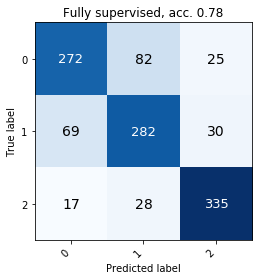

In [64]:
clf.fit(X_w, y_w)
clf_proba = clf.predict_proba(X_wt_test)
clf_pred = clf_proba.argmax(axis=1)

cm = confusion_matrix(y_wt_test, clf_pred)
_ = plot_confusion_matrix(
        cm, title='Fully supervised, acc. {:.3}'.format((y_wt_test == clf_pred).mean()))

print('Coefficients')
print(clf.coef_)
print('Intercepts')
print(clf.intercept_)

# 3. Our proposed method

## 3.a. Estimate the mixing matrix $M_{0}$

We do an initial estimate of the mixing process of the weak set using the training available with both weak and true labels

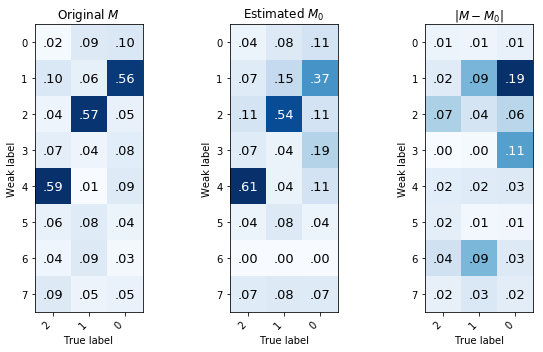

In [66]:
M_0 = estimate_M(Z_wt_train, Y_wt_train, range(n_classes), reg='Partial')

fig = plt.figure(figsize=(10, 5))
for i, (title, m) in enumerate([(r'Original $M$', M),
                                (r'Estimated $M_0$', M_0),
                                (r'$|M - M_0|$', np.abs(M - M_0))]):
    ax = fig.add_subplot(1,3,i+1)
    fig = plot_heatmap(m, title=title, fig=fig, ax=ax, columns=list(reversed(range(n_classes))),
                       xlabel='True label', ylabel='Weak label')

## 3.b. Combine the mixing matrices

We define the mixing matrix for the dataset with true labels with a perfect identity matrix $M_1 = I$. And create the final mixing matrix by concatenating and scaling both mixing matrices by $q_d$

$$M_{EM} = \binom{q_0 M_0}{q_1 I}$$

<font color='red'>ENSURE THAT THE MATRIX IS CORRECT AS THE IDENTITY PART HAS THE LABELS IN THE OPOSITE DIRECTION</font>

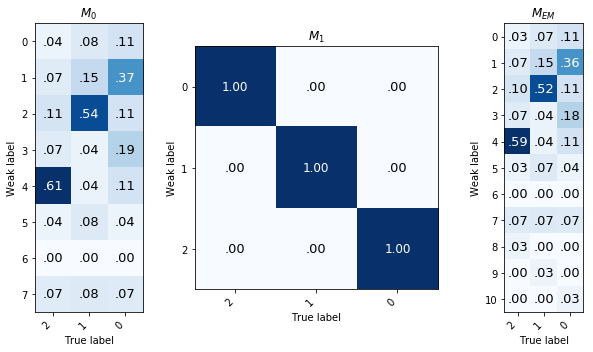

In [68]:
M_1 = computeM(c=n_classes, method='supervised')
q_0 = len(X_w)/ float(len(X_w) + len(X_wt_train))
q_1 = len(X_wt_train)/ float(len(X_w) + len(X_wt_train))
M_EM = np.concatenate((q_0*M_0, q_1*M_1))

fig = plt.figure(figsize=(10, 5))
for i, (title, m) in enumerate([('$M_0$', M_0), ('$M_1$', M_1), ('$M_{EM}$', M_EM)]):
    ax = fig.add_subplot(1,3,i+1)
    fig = plot_heatmap(m, title=title, fig=fig, ax=ax, columns=list(reversed(range(n_classes))),
                       xlabel='True label', ylabel='Weak label')

## 3.c. Count of every indice in the training set

The following plots show the count of every weak label in the set with only Weak labels, and the set with weak and true labels

Example of true labels
[1 2 1 0 1]
[[0 1 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 0]]
Corresponding indices to the matrix
[ 9 10  9  8  9]
Example of weak labels
[[0 0 1]
 [0 0 0]
 [1 0 1]
 [0 0 1]
 [1 1 1]]
Corresponding indices to the matrix
[1 0 5 1 7]


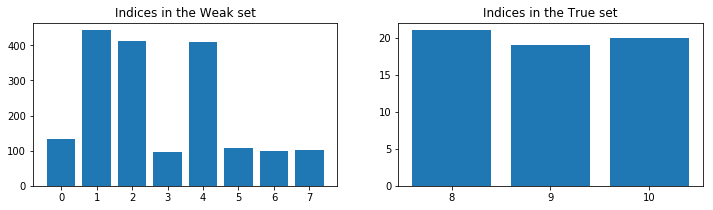

In [69]:
from wlc.WLweakener import weak_to_index
from collections import Counter

Z_w_index = weak_to_index(Z_w, method='Mproper')
Y_wt_index = weak_to_index(Y_wt_train, method='supervised') + len(M_0)

print('Example of true labels')
print(y_wt_train[:5])
print(Y_wt_train[:5])
print('Corresponding indices to the matrix')
print(Y_wt_index[:5])

print('Example of weak labels')
print(Z_w[:5])
print('Corresponding indices to the matrix')
print(Z_w_index[:5])

fig = plt.figure(figsize=(12, 3))
for i, (title, indices) in enumerate([('Indices in the Weak set', Z_w_index),
                                      ('Indices in the True set', Y_wt_index)]):
    labels, values = zip(*sorted(Counter(indices).items()))
    indexes = range(len(labels))
    ax = fig.add_subplot(1, 2, i+1)
    ax.set_title(title)
    ax.bar(indexes, values)
    ax.set_xticks(indexes)
    ax.set_xticklabels(labels)

## 3.d. Sample of weak samples using $M_{EM}$

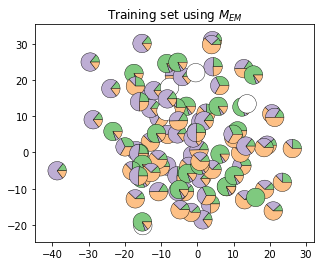

In [72]:
from sklearn.utils import shuffle

Z_index_train = np.concatenate((Z_w_index, Y_wt_index))

X_train = np.concatenate((X_w, X_wt_train))

X_train, Z_index_train = shuffle(X_train, Z_index_train)

Z_train = np.array(M_EM[Z_index_train])

fig = plt.figure(figsize=(5, 4))
_ = plot_multilabel_scatter(X_train[:100], Z_train[:100], title='Training set using $M_{EM}$', cmap=cmap, fig=fig)

## 3.e. Definition of a Logistic Regression in Keras

In [74]:
from keras.models import Sequential
from keras.layers import Dense
# from theano import tensor as T
import tensorflow as tf

# def log_loss(y_true, y_pred):
#     return T.mean(T.sum(-y_true*T.log(y_pred), axis=1))

def log_loss(target, output):
    """Categorical crossentropy between an output tensor and a target tensor.
    # Arguments
        output: A tensor resulting from a softmax
            (unless `from_logits` is True, in which
            case `output` is expected to be the logits).
        target: A tensor of the same shape as `output`.
        from_logits: Boolean, whether `output` is the
            result of a softmax, or is a tensor of logits.
    # Returns
        Output tensor.
    """

    # scale preds so that the class probas of each sample sum to 1
    output /= tf.reduce_sum(output,
                            axis=len(output.get_shape()) - 1,
                            keep_dims=True)
    # manual computation of crossentropy
    epsilon = tf.convert_to_tensor(1e-16)
    output = tf.clip_by_value(output, epsilon, 1. - epsilon)

    return - tf.reduce_sum(target * tf.log(output),
                           axis=len(output.get_shape()) - 1)

model = Sequential() 
model.add(Dense(n_classes, input_dim=n_features, activation='softmax')) 
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.compile(loss=log_loss, optimizer='adam', metrics=['accuracy'])
print("Finished!")


Finished!


## 3.f. Training with Expectation Maximization

### 3.f.E-step: Expectation step

$$q_k^{(t)} = \frac{diag(f_k^{(t)}) M^T z_k}{z_k^T M f_k^{(t)}}$$

### 3.f.M-step: Maximization step

$$W^{(t+1)} = W^{(t)} + \rho^{(t)} \sum_{k=0}^{K-1} \left(q_k^{(t)} - f_k^{(t)}\right) x_k^T$$

where $\rho^{(t)}$ is the learning step

In [ ]:
### SUPERVISED LEARNING TEST
from keras.utils import to_categorical
Y1h = to_categorical(y_wt_train)

loss = []
history = model.fit(X_wt_train, Y1h, 
                    epochs=1000, batch_size=8, verbose=0)
loss.append(history.history['loss'])

print("Let's see...")
clf_proba_wt_test = model.predict_proba(X_wt_test)
clf_pred_wt_test = numpy.argmax(clf_proba_wt_test, axis=1)
cm = confusion_matrix(y_wt_test, clf_pred_wt_test)

from experiments.visualizations import plot_confusion_matrix
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
_ = ax1.plot(loss)
ax2 = fig.add_subplot(1, 2, 2)
acc = (y_wt_test == clf_pred_wt_test).mean()
_ = plot_confusion_matrix(cm, ax=ax2, title='Fully supervised, acc. {:.3}'.format(acc))

In [ ]:
print(Y1h)

In [ ]:
print(y)

In [ ]:
loss = []
for epoch in range(200):
    print(f'Epoch {epoch}\r', end="")

    proba_train = model.predict_proba(X_train)
    Q = numpy.multiply(proba_train, Z_train)
    Z_em_train = Q / numpy.sum(Q, axis=1).reshape(-1, 1)
    index_is_finite = numpy.where(numpy.isfinite(numpy.sum(Z_em_train, axis=1)))[0]

    history = model.fit(X_train[index_is_finite], Z_em_train[index_is_finite], 
                        epochs=1, batch_size=16, verbose=0)
    loss.append(history.history['loss'])
    
print("Let's see...")
clf_proba_wt_test = model.predict_proba(X_wt_test)
clf_pred_wt_test = numpy.argmax(clf_proba_wt_test, axis=1)
cm = confusion_matrix(y_wt_test, clf_pred_wt_test)

from experiments.visualizations import plot_confusion_matrix
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
_ = ax1.plot(loss)
ax2 = fig.add_subplot(1, 2, 2)
acc = (y_wt_test == clf_pred_wt_test).mean()
_ = plot_confusion_matrix(cm, ax=ax2, title='Fully supervised, acc. {:.3}'.format(acc))

In [ ]:
print('Weights')
print(model.get_weights()[0])
print('Bias')
print(model.get_weights()[1])

In [ ]:
print(n_classes)